In [1]:
!ls

cyto-analysis.ipynb FCSfiles


In [2]:
#!pip install fcsparser

In [3]:
#!pip install matplotlib

In [4]:
#!pip install scipy

In [5]:
#!pip install scikit-learn

In [6]:
#!pip install flowkit

In [7]:
#!conda install python=3.11

In [8]:
!pip install flowkit

In [9]:
import os
from fcsparser import parse
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# === Path to your FCS file ===
fcs_path = "FCSfiles/yourDATA/Specimen_001_Tube_001_001.fcs"  

# === Parse the FCS file ===
meta, data = parse(fcs_path, reformat_meta=True)

# === Show Metadata ===
print("Metadata keys:")
print(meta.keys())

print("\nExample metadata entries:")
for key in list(meta.keys())[:10]:  # show first 10 keys
    print(f"{key}: {meta[key]}")

# === Optional: Show data shape ===
print(f"\nData shape: {data.shape}")
print("Columns:", list(data.columns))


Metadata keys:
dict_keys(['__header__', '$BEGINANALYSIS', '$ENDANALYSIS', '$BEGINSTEXT', '$ENDSTEXT', '$BEGINDATA', '$ENDDATA', '$FIL', '$SYS', '$TOT', '$PAR', '$MODE', '$BYTEORD', '$DATATYPE', '$NEXTDATA', 'CREATOR', 'TUBE NAME', '$SRC', 'EXPERIMENT NAME', 'GUID', '$DATE', '$BTIM', '$ETIM', 'SETTINGS', 'WINDOW EXTENSION', 'EXPORT USER NAME', 'EXPORT TIME', 'FSC ASF', 'AUTOBS', '$INST', '$TIMESTEP', 'SPILL', 'APPLY COMPENSATION', 'THRESHOLD', 'P1BS', 'P1MS', '$P2V', 'P2DISPLAY', 'P2BS', 'P2MS', '$P3V', 'P3DISPLAY', 'P3BS', 'P3MS', '$P4V', 'P4BS', 'P4MS', '$P5V', 'P5DISPLAY', 'P5BS', 'P5MS', '$P6V', 'P6DISPLAY', 'P6BS', 'P6MS', '$P7V', 'P7BS', 'P7MS', '$P8S', '$P8V', 'P8DISPLAY', 'P8BS', 'P8MS', '$P9S', '$P9V', 'P9DISPLAY', 'P9BS', 'P9MS', '$P10S', '$P10V', 'P10DISPLAY', 'P10BS', 'P10MS', '$P11S', '$P11V', 'P11DISPLAY', 'P11BS', 'P11MS', '$P12S', '$P12V', 'P12DISPLAY', 'P12BS', 'P12MS', '$P13S', '$P13V', 'P13DISPLAY', 'P13BS', 'P13MS', 'CST BEADS EXPIRED', '_channels_', '_channel_names_

In [11]:
# === Plot all gates in one figure ===
def plot_all_gates_subplot():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    plots = [
        # Row 1
        (data, "CD45", "SSC-A", cd45_pos, cd45_gate, "CD45+ Gate"),
        (cd45_pos, "CD3", "SSC-A", cd3_pos, cd3_pos_gate, "CD3+ T Cells"),
        (cd45_pos, "CD3", "SSC-A", cd3_neg, cd3_neg_gate, "CD3− Non-T Cells"),
        # Row 2
        (cd3_pos, "CD4", "SSC-A", cd4_pos, cd4_gate, "CD4+ Helper T Cells"),
        (cd3_pos, "CD8", "SSC-A", cd8_pos, cd8_gate, "CD8+ Cytotoxic T Cells"),
        (cd3_neg, "CD20", "SSC-A", cd20_pos, cd20_gate, "CD20+/CD19+ B Cells"),
    ]

    for ax, (df, x, y, gated_df, gate, title) in zip(axes, plots):
        ax.scatter(df[x], df[y], s=1, alpha=0.2, label='Parent')
        ax.scatter(gated_df[x], gated_df[y], s=1, alpha=0.6, color='green', label='Gated In')
        polygon = PlotPolygon(gate, edgecolor='red', fill=False, linewidth=2, label='Gate')
        ax.add_patch(polygon)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(title)
        ax.grid(True)
        ax.legend(fontsize="small")

    plt.tight_layout()
    plt.show()

In [12]:
#!pip install fcsparser matplotlib numpy pandas
#!pip install cytoflow

# === Utility: apply polygon gate ===
def apply_polygon_gate(df, x_col, y_col, vertices):
    gate_path = Path(vertices)
    points = df[[x_col, y_col]].values
    mask = gate_path.contains_points(points)
    return df[mask]


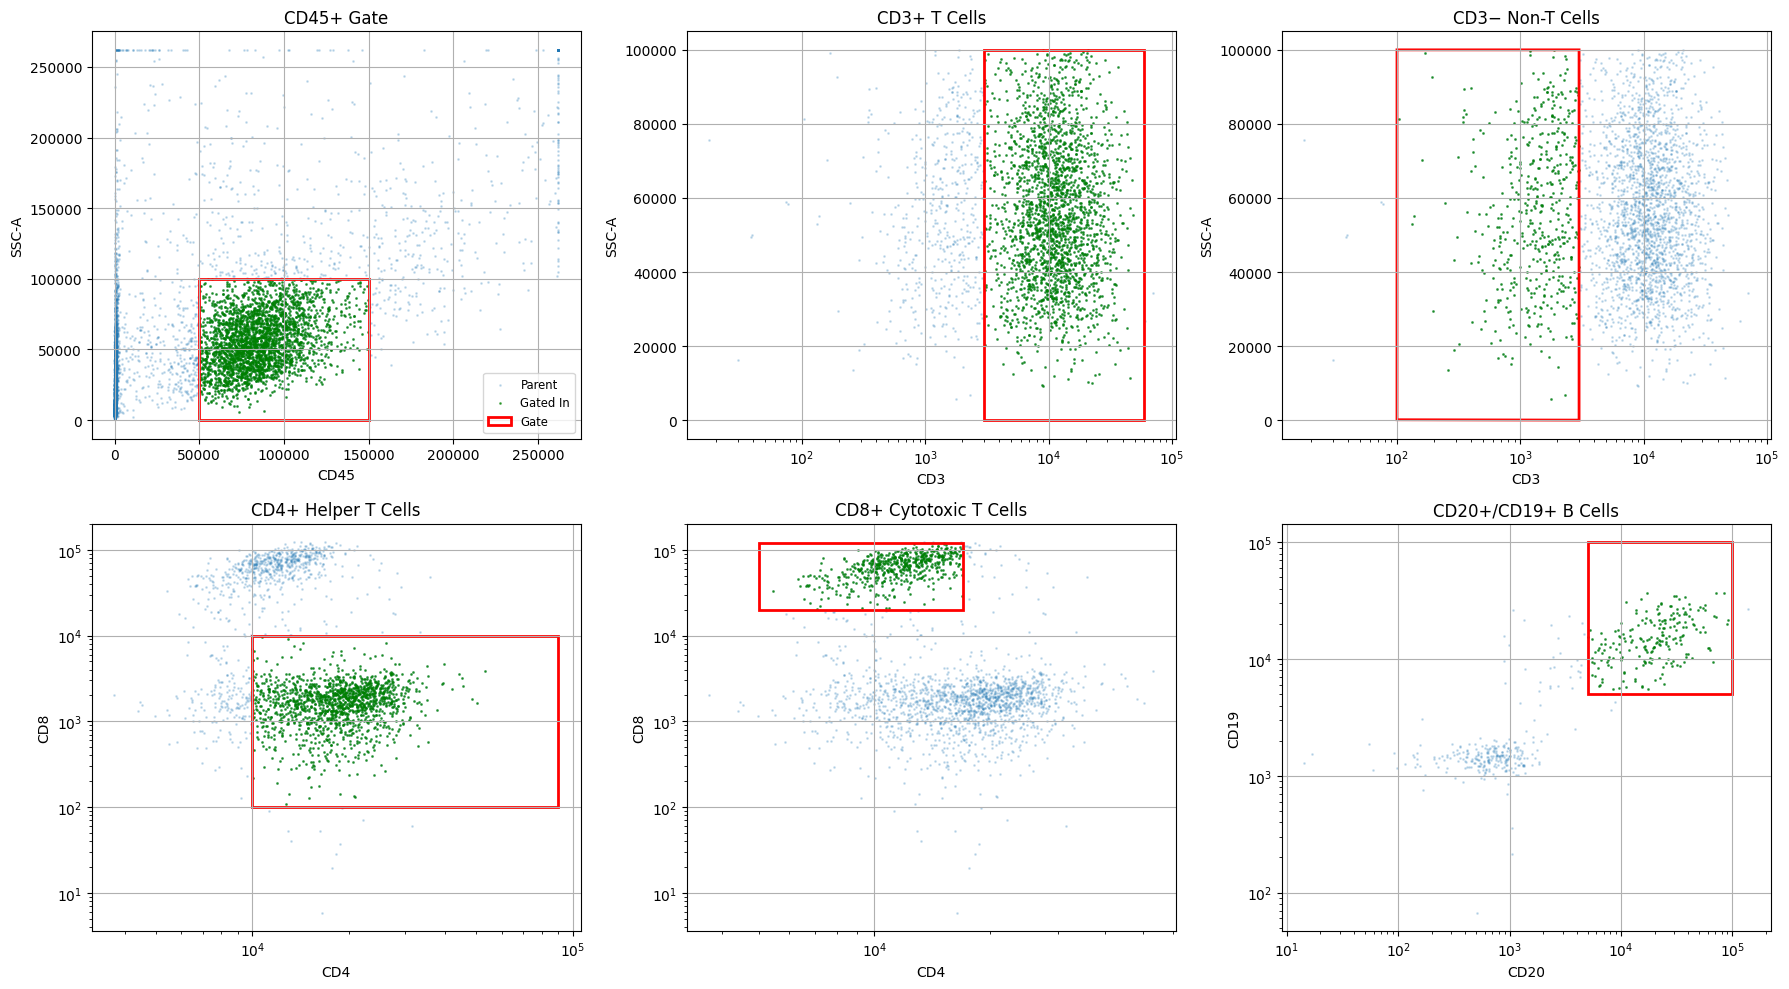

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PlotPolygon
from matplotlib.path import Path
from fcsparser import parse

# === Load FCS file ===
fcs_path = "FCSfiles/yourDATA/Specimen_001_Tube_001_001.fcs"
meta, data = parse(fcs_path, reformat_meta=True)


# === Gate definitions ===
cd45_gate = [
    (50000, 0),       # Bottom-left corner (low CD45, low SSC-A)
    (50000, 100000),   # Top-left corner (low CD45, high SSC-A)
    (150000, 100000),  # Top-right corner (high CD45, high SSC-A)
    (150000, 0)       # Bottom-right corner (high CD45, low SSC-A)
]

cd3_pos_gate = [
    (3000, 0),
    (3000, 100000),
    (60000, 100000),
    (60000, 0)
]

cd3_neg_gate = [
    (100, 100),
    (100, 100000),
    (3000, 100000),
    (3000, 0)
]

# CD4+/CD8− region
cd4_gate = [
    (10000, 100),
    (10000, 10000),
    (90000, 10000),
    (90000, 100)
]

# CD4−/CD8+ region
cd8_gate = [
    (5000, 20000),
    (5000, 120000),
    (17000, 120000),
    (17000, 20000)
]

cd20_gate = [  # CD20+ / CD19+ double-positive region
    (5000, 5000),
    (5000, 100000),
    (100000, 100000),
    (100000, 5000)
]

# === Gating Steps ===
cd45_pos = apply_polygon_gate(data, "CD45", "SSC-A", cd45_gate)
cd3_pos = apply_polygon_gate(cd45_pos, "CD3", "SSC-A", cd3_pos_gate)
cd3_neg = apply_polygon_gate(cd45_pos, "CD3", "SSC-A", cd3_neg_gate)
cd4_pos = apply_polygon_gate(cd3_pos, "CD4", "CD8", cd4_gate)
cd8_pos = apply_polygon_gate(cd3_pos, "CD4", "CD8", cd8_gate)
cd20_pos = apply_polygon_gate(cd3_neg, "CD20", "CD19", cd20_gate)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ax_cd45, ax_cd3_pos, ax_cd3_neg, ax_cd4, ax_cd8, ax_cd20_19 = axes.flatten()
# === CD45+ Gate ===
ax_cd45.scatter(data["CD45"], data["SSC-A"], s=1, alpha=0.2, label='Parent')
ax_cd45.scatter(cd45_pos["CD45"], cd45_pos["SSC-A"], s=1, alpha=0.6, color='green', label='Gated In')
ax_cd45.add_patch(PlotPolygon(cd45_gate, edgecolor='red', fill=False, linewidth=2, label='Gate'))
ax_cd45.set_title("CD45+ Gate")
ax_cd45.set_xlabel("CD45")
ax_cd45.set_ylabel("SSC-A")
ax_cd45.grid(True)
ax_cd45.legend(fontsize="small")

# === CD3+ T Cells ===
ax_cd3_pos.scatter(cd45_pos["CD3"], cd45_pos["SSC-A"], s=1, alpha=0.2)
ax_cd3_pos.scatter(cd3_pos["CD3"], cd3_pos["SSC-A"], s=1, alpha=0.6, color='green')
ax_cd3_pos.add_patch(PlotPolygon(cd3_pos_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd3_pos.set_title("CD3+ T Cells")
ax_cd3_pos.set_xlabel("CD3")
ax_cd3_pos.set_ylabel("SSC-A")
ax_cd3_pos.set_xscale("log")
ax_cd3_pos.grid(True)

# === CD3− Non-T Cells ===
ax_cd3_neg.scatter(cd45_pos["CD3"], cd45_pos["SSC-A"], s=1, alpha=0.2)
ax_cd3_neg.scatter(cd3_neg["CD3"], cd3_neg["SSC-A"], s=1, alpha=0.6, color='green')
ax_cd3_neg.add_patch(PlotPolygon(cd3_neg_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd3_neg.set_title("CD3− Non-T Cells")
ax_cd3_neg.set_xlabel("CD3")
ax_cd3_neg.set_ylabel("SSC-A")
ax_cd3_neg.set_xscale("log")
ax_cd3_neg.grid(True)

# === CD4+ Helper T Cells ===
ax_cd4.scatter(cd3_pos["CD4"], cd3_pos["CD8"], s=1, alpha=0.2)
ax_cd4.scatter(cd4_pos["CD4"], cd4_pos["CD8"], s=1, alpha=0.6, color='green')
ax_cd4.add_patch(PlotPolygon(cd4_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd4.set_title("CD4+ Helper T Cells")
ax_cd4.set_xlabel("CD4")
ax_cd4.set_ylabel("CD8")
ax_cd4.set_xscale("log")
ax_cd4.set_yscale("log")
ax_cd4.grid(True)

# === CD8+ Cytotoxic T Cells ===
ax_cd8.scatter(cd3_pos["CD4"], cd3_pos["CD8"], s=1, alpha=0.2)
ax_cd8.scatter(cd8_pos["CD4"], cd8_pos["CD8"], s=1, alpha=0.6, color='green')
ax_cd8.add_patch(PlotPolygon(cd8_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd8.set_title("CD8+ Cytotoxic T Cells")
ax_cd8.set_xlabel("CD4")
ax_cd8.set_ylabel("CD8")
ax_cd8.set_xscale("log")
ax_cd8.set_yscale("log")
ax_cd8.grid(True)

# === CD20+/CD19+ B Cells ===
ax_cd20_19.scatter(cd3_neg["CD20"], cd3_neg["CD19"], s=1, alpha=0.2)
ax_cd20_19.scatter(cd20_pos["CD20"], cd20_pos["CD19"], s=1, alpha=0.6, color='green')
ax_cd20_19.add_patch(PlotPolygon(cd20_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd20_19.set_title("CD20+/CD19+ B Cells")
ax_cd20_19.set_xlabel("CD20")
ax_cd20_19.set_ylabel("CD19")
ax_cd20_19.set_xscale("log")
ax_cd20_19.set_yscale("log")
ax_cd20_19.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# === Summary Output ===
print(f"CD45+ cells: {len(cd45_pos)}")
print(f"  └─ CD3+ T cells: {len(cd3_pos)}")
print(f"      ├─ CD4+ helper T: {len(cd4_pos)}")
print(f"      └─ CD8+ cytotoxic T: {len(cd8_pos)}")
print(f"  └─ CD3− non-T cells: {len(cd3_neg)}")
print(f"      └─ CD20+/CD19+ B cells: {len(cd20_pos)}")

CD45+ cells: 2821
  └─ CD3+ T cells: 2291
      ├─ CD4+ helper T: 1442
      └─ CD8+ cytotoxic T: 568
  └─ CD3− non-T cells: 503
      └─ CD20+/CD19+ B cells: 211


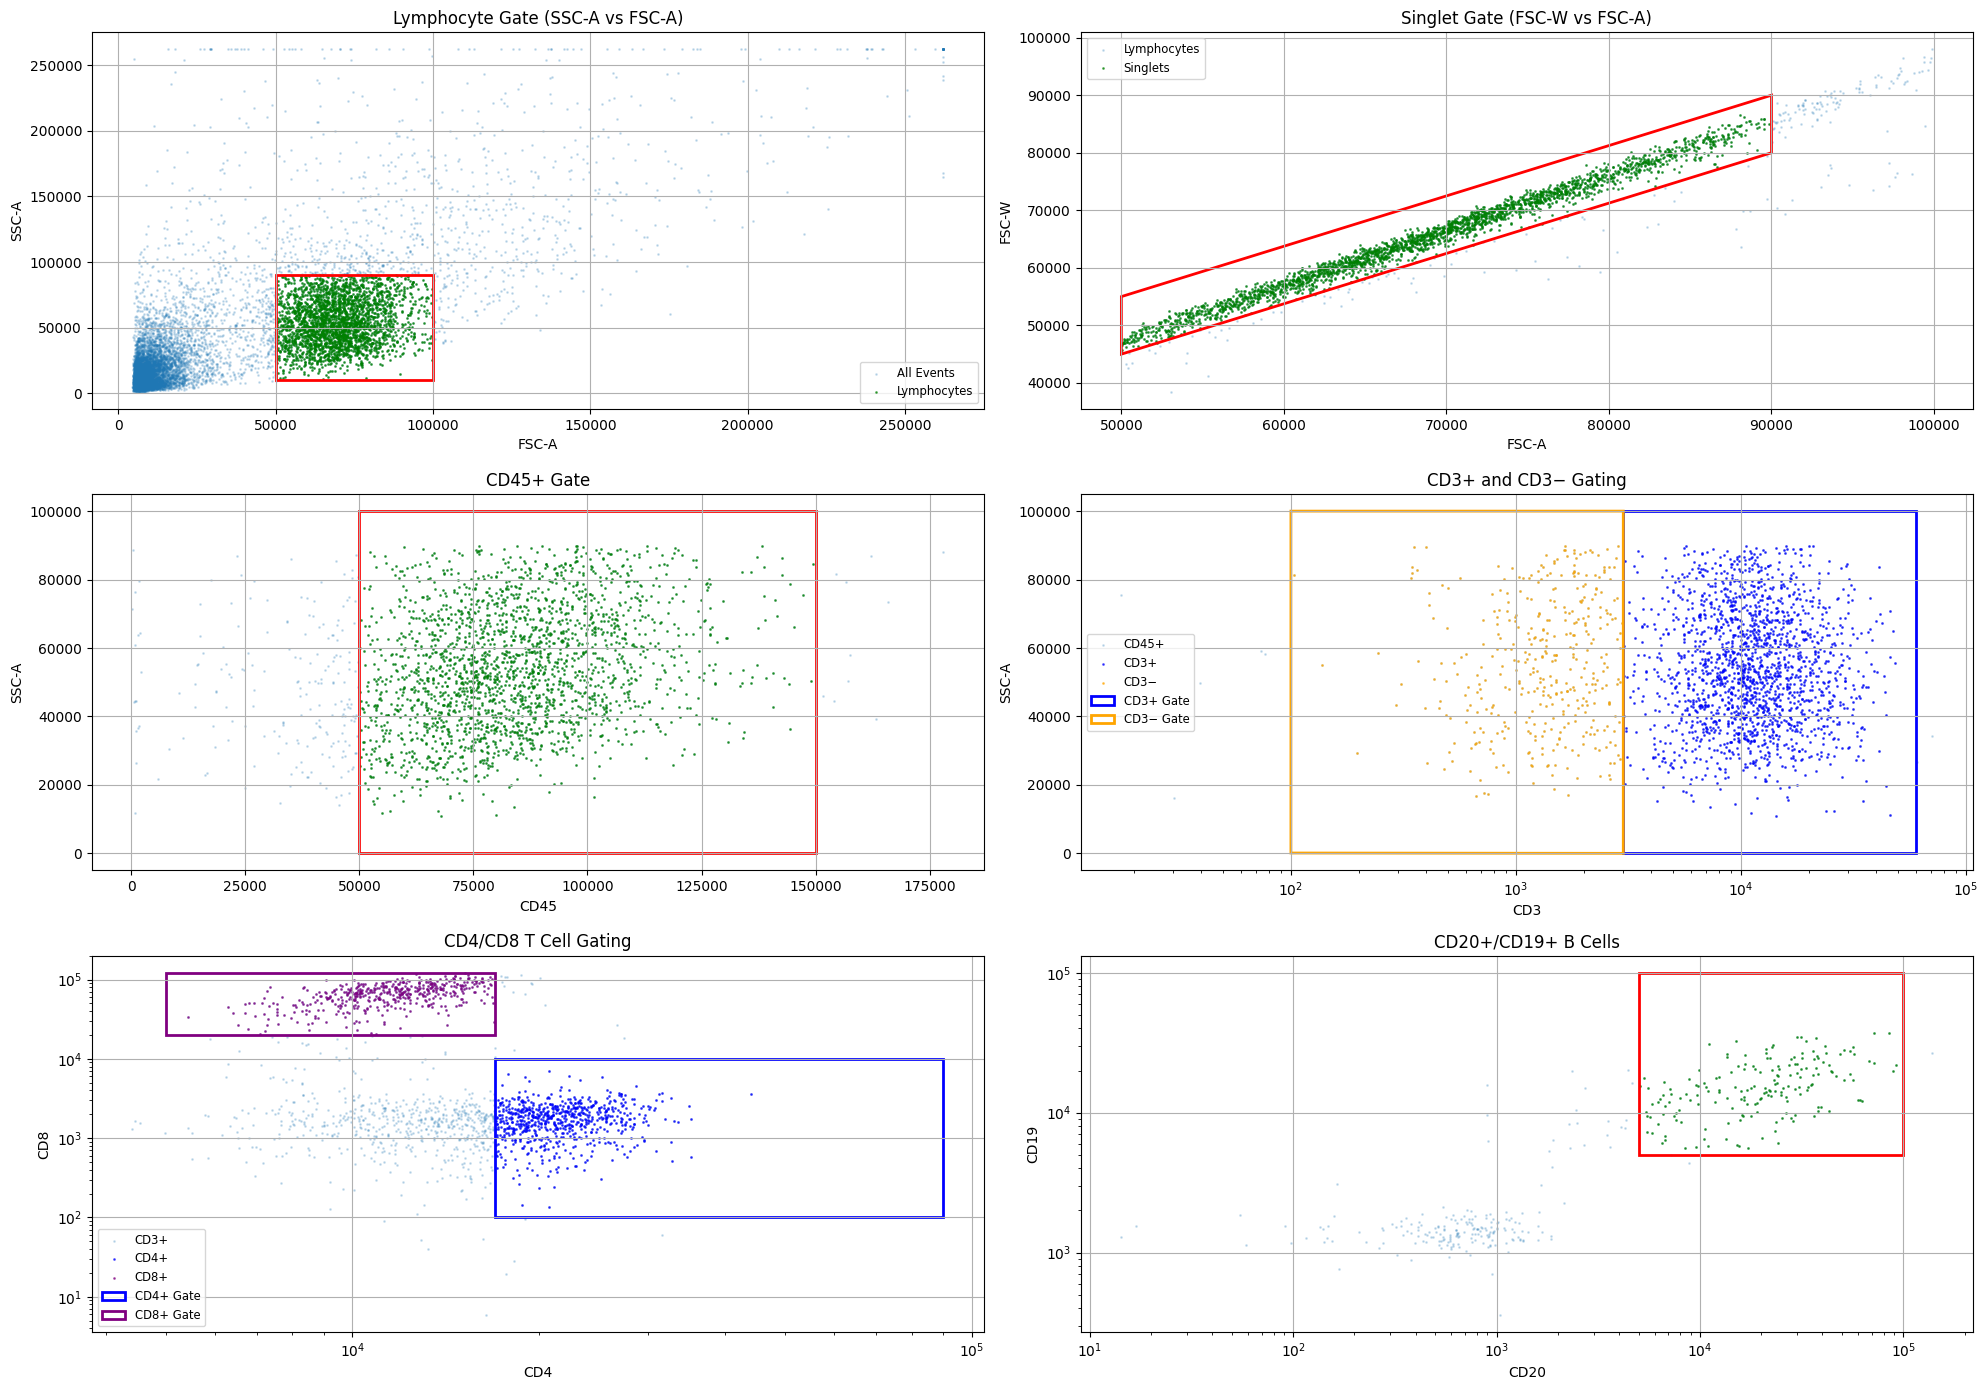

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PlotPolygon
from matplotlib.path import Path
from fcsparser import parse

# === Load FCS file ===
fcs_path = "FCSfiles/yourDATA/Specimen_001_Tube_001_001.fcs"
meta, data = parse(fcs_path, reformat_meta=True)

# === Utility: apply polygon gate ===
def apply_polygon_gate(df, x_col, y_col, vertices):
    gate_path = Path(vertices)
    points = df[[x_col, y_col]].values
    mask = gate_path.contains_points(points)
    return df[mask]

# === Gate Definitions ===

# Step 0a: Lymphocyte gate (SSC-A vs FSC-A)
lymph_gate = [
    (50000, 10000),
    (50000, 90000),
    (100000, 90000),
    (100000, 10000)
]

# Step 0b: Singlet gate (FSC-W vs FSC-A)
singlet_gate = [
    (50000, 45000),
    (50000, 55000),
    (90000, 90000),
    (90000, 80000)
]

# Step 1: CD45+ (SSC-A vs CD45)
cd45_gate = [
    (50000, 0),
    (50000, 100000),
    (150000, 100000),
    (150000, 0)
]

# Step 2: CD3 gates
cd3_pos_gate = [
    (3000, 0),
    (3000, 100000),
    (60000, 100000),
    (60000, 0)
]
cd3_neg_gate = [
    (100, 100),
    (100, 100000),
    (3000, 100000),
    (3000, 0)
]

# Step 3: CD4+/CD8− and CD4−/CD8+ T-cell gates
cd4_gate = [
    (17000, 100),
    (17000, 10000),
    (90000, 10000),
    (90000, 100)
]

cd8_gate = [
    (5000, 20000),
    (5000, 120000),
    (17000, 120000),
    (17000, 20000)
]

# Step 4: CD20+/CD19+ B-cell gate
cd20_gate = [
    (5000, 5000),
    (5000, 100000),
    (100000, 100000),
    (100000, 5000)
]

# === Gating Steps ===

# Step 0: Lymphocyte and Singlet pre-gating
lymphocytes = apply_polygon_gate(data, "FSC-A", "SSC-A", lymph_gate)
singlets = apply_polygon_gate(lymphocytes, "FSC-A", "FSC-W", singlet_gate)

# Step 1: CD45+
cd45_pos = apply_polygon_gate(singlets, "CD45", "SSC-A", cd45_gate)

# Step 2: CD3+/CD3−
cd3_pos = apply_polygon_gate(cd45_pos, "CD3", "SSC-A", cd3_pos_gate)
cd3_neg = apply_polygon_gate(cd45_pos, "CD3", "SSC-A", cd3_neg_gate)

# Step 3: CD4+ and CD8+ T cells (from CD3+)
cd4_pos = apply_polygon_gate(cd3_pos, "CD4", "CD8", cd4_gate)
cd8_pos = apply_polygon_gate(cd3_pos, "CD4", "CD8", cd8_gate)

# Step 4: B cells (CD20+/CD19+ from CD3−)
cd20_pos = apply_polygon_gate(cd3_neg, "CD20", "CD19", cd20_gate)




# === Plotting: 3x3 grid ===
fig, axes = plt.subplots(3, 2, figsize=(20, 14))
axes = axes.flatten()

# Assign axes
(ax_lymph, ax_singlet, ax_cd45,
 ax_cd3_combined, ax_cd4_cd8, ax_cd20_19) = axes  # last 3 unused

# Plot 1: Lymphocyte gate
ax_lymph.scatter(data["FSC-A"], data["SSC-A"], s=1, alpha=0.2, label='All Events')
ax_lymph.scatter(lymphocytes["FSC-A"], lymphocytes["SSC-A"], s=1, alpha=0.6, color='green', label='Lymphocytes')
ax_lymph.add_patch(PlotPolygon(lymph_gate, edgecolor='red', fill=False, linewidth=2))
ax_lymph.set_title("Lymphocyte Gate (SSC-A vs FSC-A)")
ax_lymph.set_xlabel("FSC-A")
ax_lymph.set_ylabel("SSC-A")
ax_lymph.grid(True)
ax_lymph.legend(fontsize="small")

# Plot 2: Singlet gate
ax_singlet.scatter(lymphocytes["FSC-A"], lymphocytes["FSC-W"], s=1, alpha=0.2, label='Lymphocytes')
ax_singlet.scatter(singlets["FSC-A"], singlets["FSC-W"], s=1, alpha=0.6, color='green', label='Singlets')
ax_singlet.add_patch(PlotPolygon(singlet_gate, edgecolor='red', fill=False, linewidth=2))
ax_singlet.set_title("Singlet Gate (FSC-W vs FSC-A)")
ax_singlet.set_xlabel("FSC-A")
ax_singlet.set_ylabel("FSC-W")
ax_singlet.grid(True)
ax_singlet.legend(fontsize="small")

# Plot 3: CD45+ gate
ax_cd45.scatter(singlets["CD45"], singlets["SSC-A"], s=1, alpha=0.2)
ax_cd45.scatter(cd45_pos["CD45"], cd45_pos["SSC-A"], s=1, alpha=0.6, color='green')
ax_cd45.add_patch(PlotPolygon(cd45_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd45.set_title("CD45+ Gate")
ax_cd45.set_xlabel("CD45")
ax_cd45.set_ylabel("SSC-A")
ax_cd45.grid(True)

# Plot 4: CD3+ and CD3− in one plot
ax_cd3_combined.scatter(cd45_pos["CD3"], cd45_pos["SSC-A"], s=1, alpha=0.2, label="CD45+")
ax_cd3_combined.scatter(cd3_pos["CD3"], cd3_pos["SSC-A"], s=1, alpha=0.6, color='blue', label="CD3+")
ax_cd3_combined.scatter(cd3_neg["CD3"], cd3_neg["SSC-A"], s=1, alpha=0.6, color='orange', label="CD3−")
ax_cd3_combined.add_patch(PlotPolygon(cd3_pos_gate, edgecolor='blue', fill=False, linewidth=2, label="CD3+ Gate"))
ax_cd3_combined.add_patch(PlotPolygon(cd3_neg_gate, edgecolor='orange', fill=False, linewidth=2, label="CD3− Gate"))
ax_cd3_combined.set_title("CD3+ and CD3− Gating")
ax_cd3_combined.set_xlabel("CD3")
ax_cd3_combined.set_ylabel("SSC-A")
ax_cd3_combined.set_xscale("log")
ax_cd3_combined.grid(True)
ax_cd3_combined.legend(fontsize="small")

# Plot 5: CD4 vs CD8 quadrant plot
ax_cd4_cd8.scatter(cd3_pos["CD4"], cd3_pos["CD8"], s=1, alpha=0.2, label="CD3+")
ax_cd4_cd8.scatter(cd4_pos["CD4"], cd4_pos["CD8"], s=1, alpha=0.6, color='blue', label="CD4+")
ax_cd4_cd8.scatter(cd8_pos["CD4"], cd8_pos["CD8"], s=1, alpha=0.6, color='purple', label="CD8+")
ax_cd4_cd8.add_patch(PlotPolygon(cd4_gate, edgecolor='blue', fill=False, linewidth=2, label="CD4+ Gate"))
ax_cd4_cd8.add_patch(PlotPolygon(cd8_gate, edgecolor='purple', fill=False, linewidth=2, label="CD8+ Gate"))
ax_cd4_cd8.set_title("CD4/CD8 T Cell Gating")
ax_cd4_cd8.set_xlabel("CD4")
ax_cd4_cd8.set_ylabel("CD8")
ax_cd4_cd8.set_xscale("log")
ax_cd4_cd8.set_yscale("log")
ax_cd4_cd8.grid(True)
ax_cd4_cd8.legend(fontsize="small")

# Plot 6: CD20+/CD19+ B cells
ax_cd20_19.scatter(cd3_neg["CD20"], cd3_neg["CD19"], s=1, alpha=0.2)
ax_cd20_19.scatter(cd20_pos["CD20"], cd20_pos["CD19"], s=1, alpha=0.6, color='green')
ax_cd20_19.add_patch(PlotPolygon(cd20_gate, edgecolor='red', fill=False, linewidth=2))
ax_cd20_19.set_title("CD20+/CD19+ B Cells")
ax_cd20_19.set_xlabel("CD20")
ax_cd20_19.set_ylabel("CD19")
ax_cd20_19.set_xscale("log")
ax_cd20_19.set_yscale("log")
ax_cd20_19.grid(True)

# Final layout
plt.tight_layout()
plt.show()


In [43]:
# === Summary Output ===
print(f"Lymphocytes: {len(lymphocytes)}")
print(f"Singlets: {len(singlets)}")
print(f"CD45+ cells: {len(cd45_pos)}")
print(f"  └─ CD3+ T cells: {len(cd3_pos)}")
print(f"      ├─ CD4+ helper T: {len(cd4_pos)}")
print(f"      └─ CD8+ cytotoxic T: {len(cd8_pos)}")
print(f"  └─ CD3− non-T cells: {len(cd3_neg)}")
print(f"      └─ CD20+/CD19+ B cells: {len(cd20_pos)}")

Lymphocytes: 2677
Singlets: 2474
CD45+ cells: 2264
  └─ CD3+ T cells: 1847
      ├─ CD4+ helper T: 704
      └─ CD8+ cytotoxic T: 477
  └─ CD3− non-T cells: 395
      └─ CD20+/CD19+ B cells: 182
